# Análisis y predicción de flujos de movilidad vacacional en España Peninsula-Islas

## 0. Installs and Imports

In [137]:
# Installs
#%pip install -q -U matplotlib numpy pandas scikit-learn seaborn
#%pip install xgboost

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pickle

## 1. Load Data

In [139]:
path_2022 = "../data/movilidad_provincias_2022.csv"
path_2023 = "../data/movilidad_provincias_2023.csv"
path_2024 = "../data/movilidad_provincias_2024.csv"

original_data_2022 = pd.read_csv(path_2022, sep=",")
original_data_2023 = pd.read_csv(path_2023, sep=",")
original_data_2024 = pd.read_csv(path_2024, sep=",")

df_2022 = original_data_2022.copy()
df_2023 = original_data_2023.copy()
df_2024 = original_data_2024.copy()

df = pd.concat([df_2022, df_2023, df_2024])

In [140]:
""" df_2022.info()
df_2022.head() """

' df_2022.info()\ndf_2022.head() '

## 2. Data Preparation

### 2.1 Dataset Exploratory Data Analysis (EDA)

In [141]:
# TODO: EDA (passar aqui del notebook del eda)

### 2.2 Data Wrangling
All this process is known as **Data Wrangling**. In particular, the whole data wrangling process implies:
- Define and apply an strategy for nulls and coding for categorical variables
- Analyze the variables distribution and correlation between them
- Remove outliers
- etc....

In [142]:
# Data cleaning

In [143]:
# DATA FILTERING
# Keep only the rows with destination province = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
insular_provinces = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
df = df[df['provincia_destino_name'].isin(insular_provinces)]
df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,day
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01
...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30


## 3. Feature extraction

In [144]:
features_df = df.copy()

# Add two new columns, day_of_week and month
features_df['date'] = pd.to_datetime(features_df['day'])
features_df['day_of_week'] = features_df['date'].dt.day_name()
features_df['month'] = features_df['date'].dt.month
features_df['year'] = features_df['date'].dt.year
features_df.drop(columns=['day'], inplace=True)

features_df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,date,day_of_week,month,year
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01,Thursday,9,2022
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01,Thursday,9,2022
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01,Thursday,9,2022
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01,Thursday,9,2022
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01,Thursday,9,2022
...,...,...,...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30,Monday,9,2024
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30,Monday,9,2024
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30,Monday,9,2024
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30,Monday,9,2024


In [145]:
# Sum all the trips to the same destination province
total_llegadas_islas = features_df.groupby(['date', 'provincia_destino_name', 'day_of_week', 'month', 'year'])['viajes'].sum().reset_index()
total_llegadas_islas

,date,provincia_destino_name,day_of_week,month,year,viajes
0,2022-09-01,"Balears, Illes",Thursday,9,2022,27489
1,2022-09-01,"Palmas, Las",Thursday,9,2022,17094
2,2022-09-01,Santa Cruz de Tenerife,Thursday,9,2022,14233
3,2022-09-02,"Balears, Illes",Friday,9,2022,29444
4,2022-09-02,"Palmas, Las",Friday,9,2022,16292
...,...,...,...,...,...,...
2275,2024-09-29,"Palmas, Las",Sunday,9,2024,18728
2276,2024-09-29,Santa Cruz de Tenerife,Sunday,9,2024,17824
2277,2024-09-30,"Balears, Illes",Monday,9,2024,26655
2278,2024-09-30,"Palmas, Las",Monday,9,2024,19614


In [146]:
# Export to csv for the web app
data_to_export = total_llegadas_islas.copy()

## 3.3 Prova amb tipus de transport (descartat)

In [147]:
""" # Agrupar numeros de viajes por mes
total_llegadas_islas_mes = total_llegadas_islas.groupby(['provincia_destino_name', 'month', 'year'])['viajes'].sum().reset_index()
total_llegadas_islas_mes_baleares = total_llegadas_islas_mes[total_llegadas_islas_mes['provincia_destino_name'] == 'Balears, Illes']
total_llegadas_islas_mes_baleares[total_llegadas_islas_mes_baleares['year'] == 2023] """

" # Agrupar numeros de viajes por mes\ntotal_llegadas_islas_mes = total_llegadas_islas.groupby(['provincia_destino_name', 'month', 'year'])['viajes'].sum().reset_index()\ntotal_llegadas_islas_mes_baleares = total_llegadas_islas_mes[total_llegadas_islas_mes['provincia_destino_name'] == 'Balears, Illes']\ntotal_llegadas_islas_mes_baleares[total_llegadas_islas_mes_baleares['year'] == 2023] "

In [148]:
""" # Cargar trafico aereo baleares
trafico_baleares_2023 = "../data/trafico_aereo/trafico_aereo_baleares_2023.csv"
df_bal_2023 = pd.read_csv(trafico_baleares_2023, sep=",", encoding='utf-16le')

#df_bal_2023.info()
# Pasar de object a int
df_bal_2023['Actual'] = df_bal_2023['Actual'].str.replace('.', '').astype(int)
#df_bal_2023['Mes           '] = df_bal_2023['Mes           '].str.strip()

df_bal_2023.head()

# Grafico de trafico aereo en baleares
plt.figure(figsize=(12, 6))
plt.hist(df_bal_2023['Actual'], df_bal_2023['Mes           '])
plt.title('Trafico aereo en Baleares 2023')
plt.xlabel('Pasajeros')
plt.ylabel('Mes')
plt.show() """

' # Cargar trafico aereo baleares\ntrafico_baleares_2023 = "../data/trafico_aereo/trafico_aereo_baleares_2023.csv"\ndf_bal_2023 = pd.read_csv(trafico_baleares_2023, sep=",", encoding=\'utf-16le\')\n\n#df_bal_2023.info()\n# Pasar de object a int\ndf_bal_2023[\'Actual\'] = df_bal_2023[\'Actual\'].str.replace(\'.\', \'\').astype(int)\n#df_bal_2023[\'Mes           \'] = df_bal_2023[\'Mes           \'].str.strip()\n\ndf_bal_2023.head()\n\n# Grafico de trafico aereo en baleares\nplt.figure(figsize=(12, 6))\nplt.hist(df_bal_2023[\'Actual\'], df_bal_2023[\'Mes           \'])\nplt.title(\'Trafico aereo en Baleares 2023\')\nplt.xlabel(\'Pasajeros\')\nplt.ylabel(\'Mes\')\nplt.show() '

## 4. Model

In [149]:
df1 = total_llegadas_islas.copy()
df1.drop(columns=['date'], inplace=True)
df1.drop(columns=['year'], inplace=True)

In [150]:
# Label encoding
le_day_of_week = LabelEncoder()
df1['day_of_week'] = le_day_of_week.fit_transform(df1['day_of_week'])
le_provincia_destino_name = LabelEncoder()
df1['provincia_destino_name'] = le_provincia_destino_name.fit_transform(df1['provincia_destino_name'])

### 4.1 Model Selection

In [151]:
features = df1.drop(columns=['viajes'])
target = df1['viajes']

X = features
y = target

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1710, 570, 1710, 570)

In [152]:
final_model = XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=3)
final_model.fit(X_train, y_train)
y_pred_final_model = final_model.predict(X_test)

### 4.2 Model results visualization

In [153]:
# Predicción de datos fake
isla = 'Balears, Illes'
dia = 'Wednesday'
mes = 7

fake_data = pd.DataFrame({'provincia_destino_name': [isla], 'day_of_week': [dia], 'month': [mes]})

fake_data['day_of_week'] = le_day_of_week.transform(fake_data['day_of_week'])
fake_data['provincia_destino_name'] = le_provincia_destino_name.transform(fake_data['provincia_destino_name'])

#fake_data

--------------------
XGBoost: [29365.842]
--------------------


C:\Users\pdpau\AppData\Local\Temp\ipykernel_24212\3693410057.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.bar(x_pos, int(y_pred_fake), color="red")


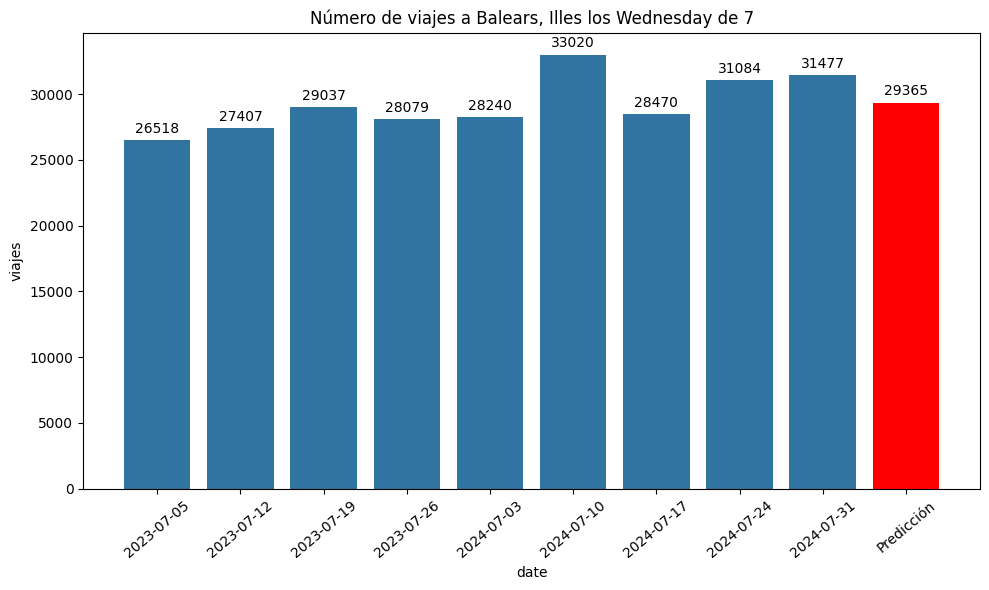

Media de viajes a Balears, Illes los Wednesday de 7: 29259.11111111111


In [154]:
# --- Predicción de datos de muestra ---
y_pred_fake = final_model.predict(fake_data)
print("--------------------")
print(f"XGBoost: {y_pred_fake}")
print("--------------------")

# -- Plot --
u = total_llegadas_islas.copy()
data_to_plot = u[(u["day_of_week"] == dia) & (u["month"] == mes) & (u["provincia_destino_name"] == isla)]

# --- Visualización datos reales ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=data_to_plot, x="date", y="viajes")

# Añadir columna de predicción
x_pos = len(data_to_plot)
ax.bar(x_pos, int(y_pred_fake), color="red")

for i in ax.containers:
    ax.bar_label(i, padding=3)

# Ajustar etiquetas del eje x
x_labels = list(data_to_plot["date"].astype(str))
x_labels.append("Predicción")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=40)

plt.title(f"Número de viajes a {isla} los {dia} de {mes}")
plt.tight_layout()
plt.show()

# Media de viajes
media_viajes = data_to_plot['viajes'].mean()
print(f"Media de viajes a {isla} los {dia} de {mes}: {media_viajes}")


## 5. Evaluation

In [155]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred_final_model)
mae = mean_absolute_error(y_test, y_pred_final_model)
r2 = r2_score(y_test, y_pred_final_model)

print("----------------------")
print(f"XGBoost: MSE = {mse}, MAE = {mae}, R2 = {r2}")
print("----------------------")

----------------------
XGBoost: MSE = 8801899.557420311, MAE = 2279.993441611842, R2 = 0.6921708221704953
----------------------


In [156]:
# EXPLAINABILITY OF THE MODEL (ELI5, LIME, SHAP) ...
""" explainer = TreeExplainer(gbr)
shap_values = explainer.shap_values(X_test) """

""" shap.force_plot(base_value, shap_values[0]) #Local explanation
shap.plots.waterfall(shap_values[i]) #Local explanation
shap.plots.bar(shap_values[i]) #Local explanation
shap.summary_plot(shap_values) #Global features importance
shap.plots.bar(shap_values.abs.mean(0), max_display=20) #Global features importance
shap.plots.scatter(shap_values[:], feature1, color=shap_value[j]) """

' shap.force_plot(base_value, shap_values[0]) #Local explanation\nshap.plots.waterfall(shap_values[i]) #Local explanation\nshap.plots.bar(shap_values[i]) #Local explanation\nshap.summary_plot(shap_values) #Global features importance\nshap.plots.bar(shap_values.abs.mean(0), max_display=20) #Global features importance\nshap.plots.scatter(shap_values[:], feature1, color=shap_value[j]) '

# 6. Export the dataset and the model

In [157]:
# Export the dataset
filename_dataset = 'dataset.csv'
#data_to_export.drop(columns=['date', 'year'], inplace=True)
data_to_export.to_csv(filename_dataset, index=False)
print(f"Dataset saved as '{filename_dataset}'")

# Export the model
filename_model = 'model.pkl'
with open(filename_model, 'wb') as file:
    pickle.dump(final_model, file)
print(f"Model saved as '{filename_model}'")

# Export the label encoders ¿?
filename_le_day_of_week = 'le_day_of_week.pkl'
filename_le_provincia_destino_name = 'le_provincia_destino_name.pkl'
with open(filename_le_day_of_week, 'wb') as file:
    pickle.dump(le_day_of_week, file)
with open(filename_le_provincia_destino_name, 'wb') as file:
    pickle.dump(le_provincia_destino_name, file)





# TODO: Importar el modelo en el web app asi:
""" @st.cache_resource
def load_model():
    with open('model.pkl', 'rb') as file:
        model = pickle.load(file)
    return model """

Dataset saved as 'dataset.csv'
Model saved as 'model.pkl'


" @st.cache_resource\ndef load_model():\n    with open('model.pkl', 'rb') as file:\n        model = pickle.load(file)\n    return model "